In [1]:
import pandas as pd

# Loading datasets
email_df = pd.read_csv("C:/Users/satyam kamal/Downloads/email_table.csv")
opened_df = pd.read_csv("C:/Users/satyam kamal/Downloads/email_opened_table.csv")
clicked_df = pd.read_csv("C:/Users/satyam kamal/Downloads/link_clicked_table.csv")

# Displaying the first few rows of each dataframe
email_df.head(), opened_df.head(), clicked_df.head()

(   email_id   email_text email_version  hour    weekday user_country  \
 0     85120  short_email  personalized     2     Sunday           US   
 1    966622   long_email  personalized    12     Sunday           UK   
 2    777221   long_email  personalized    11  Wednesday           US   
 3    493711  short_email       generic     6     Monday           UK   
 4    106887   long_email       generic    14     Monday           US   
 
    user_past_purchases  
 0                    5  
 1                    2  
 2                    2  
 3                    1  
 4                    6  ,
    email_id
 0    284534
 1    609056
 2    220820
 3    905936
 4    164034,
    email_id
 0    609056
 1    870980
 2    935124
 3    158501
 4    177561)

In [3]:
# Merging opened and clicked flags with the main email data
email_df["opened"] = email_df["email_id"].isin(opened_df["email_id"]).astype(int)
email_df["clicked"] = email_df["email_id"].isin(clicked_df["email_id"]).astype(int)

# Calculate performance metrics
total_emails = len(email_df)
opened_percentage = email_df["opened"].mean() * 100
clicked_percentage = email_df["clicked"].mean() * 100

opened_percentage, clicked_percentage

(10.345, 2.119)

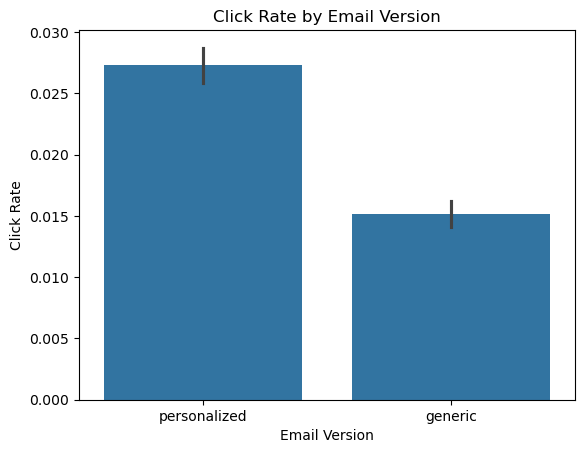

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# CTR by email version
sns.barplot(data=email_df, x="email_version", y="clicked")
plt.title("Click Rate by Email Version")
plt.ylabel("Click Rate")
plt.xlabel("Email Version")
plt.show()

In [19]:


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
df = email_df.copy()
label_encoders = {}
for col in ["email_text", "email_version", "weekday", "user_country"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
features = ["email_text", "email_version", "hour", "weekday", "user_country", "user_past_purchases"]
X = df[features]
y = df["clicked"]

# Splitting into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print(report)
print(f"ROC AUC Score: {roc_auc:.3f}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.06      0.01      0.02       424

    accuracy                           0.98     20000
   macro avg       0.52      0.50      0.50     20000
weighted avg       0.96      0.98      0.97     20000

ROC AUC Score: 0.578


In [21]:
# Adding predicted probabilities to full dataset
df["predicted_click_proba"] = model.predict_proba(X)[:, 1]

# Sending emails to top 20% most likely to click
top_20_cutoff = df["predicted_click_proba"].quantile(0.80)
df["model_selected"] = df["predicted_click_proba"] >= top_20_cutoff

# Compare actual click-through rates
original_ctr = df["clicked"].mean()
model_ctr = df[df["model_selected"]]["clicked"].mean()
print(f"Original CTR: {original_ctr:.4f}")
print(f"CTR using model targeting (top 20%): {model_ctr:.4f}")

Original CTR: 0.0212
CTR using model targeting (top 20%): 0.0912


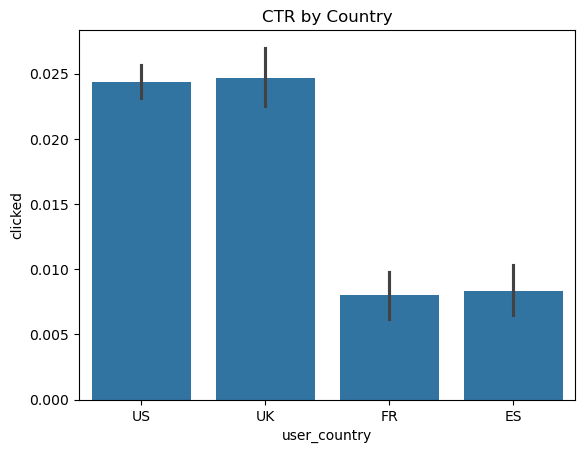

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Click-through rate by user country
sns.barplot(data=email_df, x="user_country", y="clicked")
plt.title("CTR by Country")
plt.show()
